# Compare attribution graph of benign and attacked image

- Show adversarial attacks on attribution graphs
- Attack image/class, compare graph against benign graph

## Import packages

In [2]:
# Set auto reload for python functions
%reload_ext autoreload
%autoreload 2

# Helper libraries
import cv2
import glob
import tqdm
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt

# GoogLeNet
import lucid.modelzoo.vision_models as models

# Libraries provided by Massif project
import parse
import A_matrix
import I_matrix
import model_helper

## Import GoogLeNet (InceptionV1) model

In [4]:
googlenet = models.InceptionV1()
googlenet.load_graphdef()

## Get constants and hyperparameters

In [5]:
args = parse.Args
arg_keys = [arg for arg in args.__dict__.keys() if '__' not in arg]

print('Constants and hyperparameters in args:')
print(arg_keys)

Constants and hyperparameters in args:
['gpu', 'batch_A', 'batch_I', 'layer', 'k_A', 'layer_sizes', 'layers', 'layer_blk_sizes', 'num_classes', 'img_width', 'img_height']


## Read input images

Benign image; class 102 (White wolf)


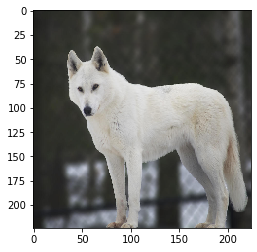

Attacked image; class 46 (Mexican_hairless)


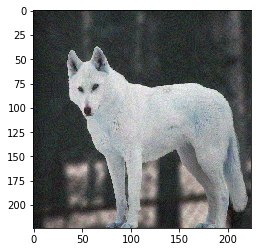

A sample image of class 46 (Mexican_hairless)


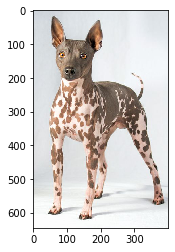

Output layer, neuron 46 has the highest value for the given attacked image


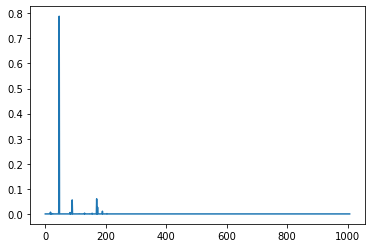

softmax value of neuron 46: 0.7883, 102: 0.0000


In [7]:
dirname = '../data/sample-images'
benign_image_path = '{}/{}'.format(dirname, 'white-wolf.jpg')
attacked_image_path = '{}/{}'.format(dirname, 'white-wolf-attacked-46.jpg')
attacked_class_image_path = '{}/{}'.format(dirname, 'american-hairless-sample.jpg')

print('Benign image; class 102 (White wolf)')
plt.figure()
raw_benign = plt.imread(benign_image_path)
raw_benign = cv2.resize(raw_benign, (args.img_width, args.img_height))
plt.imshow(raw_benign)
plt.show()

print('Attacked image; class 46 (Mexican_hairless)')
plt.figure()
raw_attacked = plt.imread(attacked_image_path)
raw_attacked = cv2.resize(raw_attacked, (args.img_width, args.img_height))
plt.imshow(raw_attacked)
plt.show()

print('A sample image of class 46 (Mexican_hairless)')
plt.figure()
attacked_class_sample = plt.imread(attacked_class_image_path)
plt.imshow(attacked_class_sample)
plt.show()

print('Output layer, neuron 46 has the highest value for the given attacked image')
y_eval, softmax_result = model_helper.get_predictions(googlenet, [raw_attacked])
plt.figure()
plt.plot(softmax_result[0])
plt.show()
print('softmax value of neuron 46: %.4lf, 102: %.4lf' % (softmax_result[0][46], softmax_result[0][102]))

## A_matrix: generate nodes

- A-matrix: shape of (#layers, #neurons)

### A_matrix of a **Benign** Image

In [8]:
As_benign = A_matrix.init_A_matrix_single_image(args)

In [9]:
act_scores_benign = model_helper.get_all_layers_activation_score(googlenet, [raw_benign], args.layers)

In [10]:
for layer in args.layers:
    As_benign[layer] = act_scores_benign[layer][0]

### A_matrix of a **Attacked** Image

In [11]:
As_attacked = A_matrix.init_A_matrix_single_image(args)

In [12]:
act_scores_attacked = model_helper.get_all_layers_activation_score(googlenet, [raw_attacked], args.layers)

In [13]:
for layer in args.layers:
    As_attacked[layer] = act_scores_attacked[layer][0]

## I_matrix: generate edges

- I_matrix for a given layer: (#neurons, #previous_neurons)

### I_matrix of a **Benign** Image

In [14]:
Is_benign = {}
for layer in args.layers:
    if layer == 'mixed3a':
        continue
    for i in range(6):
        Is_benign['{}_{}'.format(layer, i)] = [[]]

In [15]:
Is_benign = I_matrix.gen_I_matrix(args, {0: Is_benign}, [raw_benign], googlenet)

### I_matrix of a **Attacked** Image

In [16]:
Is_attacked = {}
for layer in args.layers:
    if layer == 'mixed3a':
        continue
    for i in range(6):
        Is_attacked['{}_{}'.format(layer, i)] = [[]]

In [17]:
Is_attacked = I_matrix.gen_I_matrix(args, {0: Is_attacked}, [raw_attacked], googlenet)

## Compare the results of benign and attacked images -- ex) layer = mixed4c

In [18]:
layer = 'mixed4c'
benign_activations = As_benign[layer]
attacked_activations = As_attacked[layer]

diff = benign_activations - attacked_activations
abs_diff = np.abs(diff)
sorted_neurons_benign = np.argsort(benign_activations)
sorted_neurons_attacked = np.argsort(attacked_activations)
sorted_neurons_diff = np.argsort(diff)

Compare activation, neurons sorted by benign
Ignore the x-axis numbers; they are not neurons exactly.


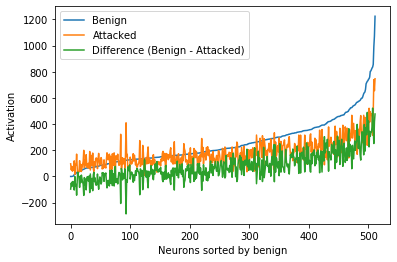

In [19]:
print('Compare activation, neurons sorted by benign')
print('Ignore the x-axis numbers; they are not neurons exactly.')
plt.plot(benign_activations[sorted_neurons_benign])
plt.plot(attacked_activations[sorted_neurons_benign])
plt.plot(diff[sorted_neurons_benign])
plt.legend(['Benign', 'Attacked', 'Difference (Benign - Attacked)'])
plt.xlabel('Neurons sorted by benign')
plt.ylabel('Activation')
plt.show()

Compare activation, neurons sorted by attacked
Ignore the x-axis numbers; they are not neurons exactly.


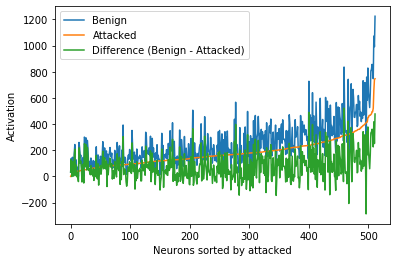

In [20]:
print('Compare activation, neurons sorted by attacked')
print('Ignore the x-axis numbers; they are not neurons exactly.')
plt.plot(benign_activations[sorted_neurons_attacked])
plt.plot(attacked_activations[sorted_neurons_attacked])
plt.plot(diff[sorted_neurons_attacked])
plt.legend(['Benign', 'Attacked', 'Difference (Benign - Attacked)'])
plt.xlabel('Neurons sorted by attacked')
plt.ylabel('Activation')
plt.show()

Compare activation, neurons sorted by difference between attacked and benign
Ignore the x-axis numbers; they are not neurons exactly.


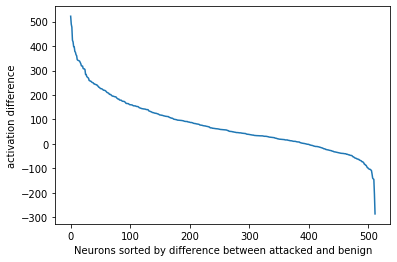

<--- More benign side      ...     More attacked side --->


In [21]:
print('Compare activation, neurons sorted by difference between attacked and benign')
print('Ignore the x-axis numbers; they are not neurons exactly.')

plt.figure()
reverse_sorted_neurons = sorted_neurons_diff[::-1]
reverse_sorted_activation = np.sort(diff)[::-1]
plt.plot(reverse_sorted_activation)
plt.ylabel("activation difference")
plt.xlabel('Neurons sorted by difference between attacked and benign')
plt.show()
print('<--- More benign side      ...     More attacked side --->')

## Find out neurons influenced by the attack
- The neurons are one of the **highly** activated ones for **attacked** image and **misclassified** class.
- The neurons are one of the **barely** activated ones for **benign** image and **original** class.

In [85]:
topk = 10
top_standard = 0.1 # 10%
low_standard = 0.3 # 30%

num_total_neurons = len(sorted_neurons_attacked)
top_rank_thresold = num_total_neurons * top_standard
low_rank_threshold = num_total_neurons * low_standard

In [95]:
rank_of_neurons_attacked = sorted_neurons_attacked[::-1]
rank_of_neurons_benign = sorted_neurons_benign[::-1]

got_activated_neurons, no_longer_activated_neurons, both_activated_neurons = [], [], []
for neuron in rank_of_neurons_attacked:
    
    rank_in_attacked = np.argwhere(rank_of_neurons_attacked == neuron)
    rank_in_benign = np.argwhere(rank_of_neurons_benign == neuron)
    
    is_responsive_to_attacked = rank_in_attacked < top_rank_thresold
    is_responsive_to_attacked = is_responsive_to_attacked[0][0]
    
    is_non_responsive_to_benign = rank_in_benign > low_rank_threshold
    is_non_responsive_to_benign = is_non_responsive_to_benign[0][0]
    
    is_non_responsive_to_attacked = rank_in_attacked > low_rank_threshold
    is_non_responsive_to_attacked = is_non_responsive_to_attacked[0][0]
    
    is_responsive_to_benign = rank_in_benign < top_rank_thresold
    is_responsive_to_benign = is_responsive_to_benign[0][0]
    
    if is_responsive_to_attacked and is_non_responsive_to_benign:
        got_activated_neurons.append(neuron)
    
    if is_non_responsive_to_attacked and is_responsive_to_benign:
        no_longer_activated_neurons.append(neuron)
    
    if is_responsive_to_attacked and is_responsive_to_benign:
        both_activated_neurons.append(neuron)

Look into neurons that got activatied by the attacked image, while was idle by benign image.
The attacked image newly got the following features to fool the model.
Neurons: [236, 245, 50, 412]

mixed4c-236
Top 81.64% in benign (White wolf) --> top 2.93% in attacked (Mexican hairless)


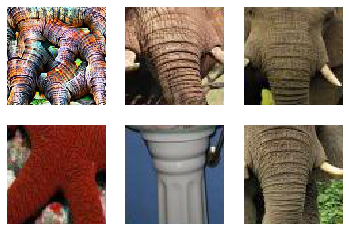

mixed4c-245
Top 33.01% in benign (White wolf) --> top 7.62% in attacked (Mexican hairless)


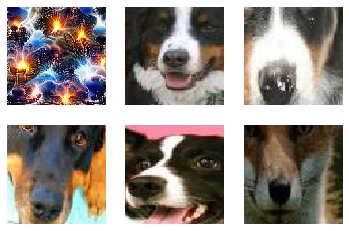

mixed4c-50
Top 83.40% in benign (White wolf) --> top 8.59% in attacked (Mexican hairless)


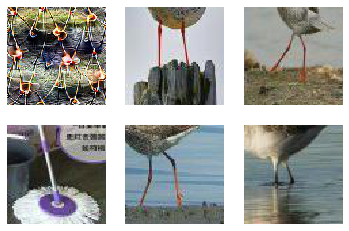

mixed4c-412
Top 38.87% in benign (White wolf) --> top 9.18% in attacked (Mexican hairless)


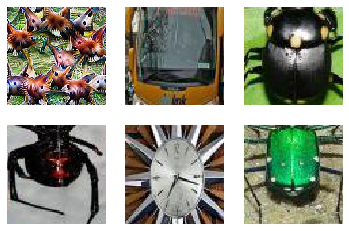

In [143]:
print('Look into neurons that got activatied by the attacked image, while was idle by benign image.')
print('The attacked image newly got the following features to fool the model.')
print('Neurons:', got_activated_neurons)
print()

vis_dirpath = '/Users/haekyu/data/summit/summit-data/data/feature-vis'
for neuron in got_activated_neurons:
    
    rank_in_attacked = np.argwhere(rank_of_neurons_attacked == neuron)
    rank_in_benign = np.argwhere(rank_of_neurons_benign == neuron)
    top_percent_in_attacked = 100 * rank_in_attacked / num_total_neurons
    top_percent_in_benign = 100 * rank_in_benign / num_total_neurons
    
    print('{}-{}'.format(layer, neuron))
    print('Top %.2lf%% in benign (White wolf) --> top %.2lf%% in attacked (Mexican hairless)' % (top_percent_in_benign, top_percent_in_attacked))
    
    plt.figure()
    
    # Feature vis
    plt.subplot(231)
    feature_vis_path = '{}/channel/{}-{}-channel.jpg'.format(vis_dirpath, layer, neuron)
    feature_vis = plt.imread(feature_vis_path)
    plt.axis('off')
    plt.imshow(feature_vis)
    
    # Example patch 0
    plt.subplot(234)
    ex0_path = '{}/dataset-p/{}-{}-dataset-p-0.jpg'.format(vis_dirpath, layer, neuron)
    ex0 = plt.imread(ex0_path)
    plt.axis('off')
    plt.imshow(ex0)
    
    # Example patch 1
    plt.subplot(232)
    ex1_path = '{}/dataset-p/{}-{}-dataset-p-1.jpg'.format(vis_dirpath, layer, neuron)
    ex1 = plt.imread(ex1_path)
    plt.axis('off')
    plt.imshow(ex1)
    
    # Example patch 2
    plt.subplot(235)
    ex2_path = '{}/dataset-p/{}-{}-dataset-p-2.jpg'.format(vis_dirpath, layer, neuron)
    ex2 = plt.imread(ex2_path)
    plt.axis('off')
    plt.imshow(ex2)
    
    # Example patch 3
    plt.subplot(233)
    ex3_path = '{}/dataset-p/{}-{}-dataset-p-3.jpg'.format(vis_dirpath, layer, neuron)
    ex3 = plt.imread(ex3_path)
    plt.axis('off')
    plt.imshow(ex3)

    # Example patch 4
    plt.subplot(236)
    ex4_path = '{}/dataset-p/{}-{}-dataset-p-4.jpg'.format(vis_dirpath, layer, neuron)
    ex4 = plt.imread(ex4_path)
    plt.axis('off')
    plt.imshow(ex4)
    
    plt.show()


Look into neurons that are no longer activated in attacked image, while was very activated by benign image.
The attacked images lose the following features.
Neurons: [236, 245, 50, 412]

mixed4c-321
Top 8.79% in benign (White wolf) --> top 41.80% in benign (Mexican hairless)


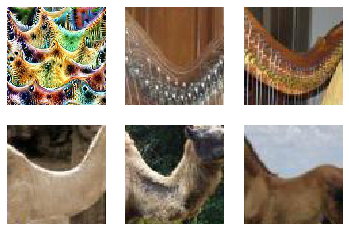

mixed4c-166
Top 5.86% in benign (White wolf) --> top 45.70% in benign (Mexican hairless)


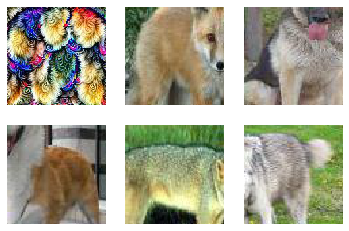

mixed4c-178
Top 8.59% in benign (White wolf) --> top 59.77% in benign (Mexican hairless)


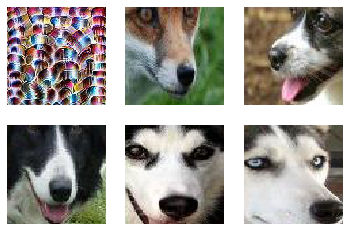

In [144]:
print('Look into neurons that are no longer activated in attacked image, while was very activated by benign image.')
print('The attacked images lose the following features.')
print('Neurons:', got_activated_neurons)
print()

vis_dirpath = '/Users/haekyu/data/summit/summit-data/data/feature-vis'
for neuron in no_longer_activated_neurons:
    
    rank_in_attacked = np.argwhere(rank_of_neurons_attacked == neuron)
    rank_in_benign = np.argwhere(rank_of_neurons_benign == neuron)
    top_percent_in_attacked = 100 * rank_in_attacked / num_total_neurons
    top_percent_in_benign = 100 * rank_in_benign / num_total_neurons
    
    print('{}-{}'.format(layer, neuron))
    print('Top %.2lf%% in benign (White wolf) --> top %.2lf%% in benign (Mexican hairless)' % (top_percent_in_benign, top_percent_in_attacked))
    
    plt.figure()
    
    # Feature vis
    plt.subplot(231)
    feature_vis_path = '{}/channel/{}-{}-channel.jpg'.format(vis_dirpath, layer, neuron)
    feature_vis = plt.imread(feature_vis_path)
    plt.axis('off')
    plt.imshow(feature_vis)
    
    # Example patch 0
    plt.subplot(234)
    ex0_path = '{}/dataset-p/{}-{}-dataset-p-0.jpg'.format(vis_dirpath, layer, neuron)
    ex0 = plt.imread(ex0_path)
    plt.axis('off')
    plt.imshow(ex0)
    
    # Example patch 1
    plt.subplot(232)
    ex1_path = '{}/dataset-p/{}-{}-dataset-p-1.jpg'.format(vis_dirpath, layer, neuron)
    ex1 = plt.imread(ex1_path)
    plt.axis('off')
    plt.imshow(ex1)
    
    # Example patch 2
    plt.subplot(235)
    ex2_path = '{}/dataset-p/{}-{}-dataset-p-2.jpg'.format(vis_dirpath, layer, neuron)
    ex2 = plt.imread(ex2_path)
    plt.axis('off')
    plt.imshow(ex2)
    
    # Example patch 3
    plt.subplot(233)
    ex3_path = '{}/dataset-p/{}-{}-dataset-p-3.jpg'.format(vis_dirpath, layer, neuron)
    ex3 = plt.imread(ex3_path)
    plt.axis('off')
    plt.imshow(ex3)

    # Example patch 4
    plt.subplot(236)
    ex4_path = '{}/dataset-p/{}-{}-dataset-p-4.jpg'.format(vis_dirpath, layer, neuron)
    ex4 = plt.imread(ex4_path)
    plt.axis('off')
    plt.imshow(ex4)
    
    plt.show()


In [89]:
print(both_activated_neurons)

[264, 216, 352, 262, 376, 407, 272, 307, 346, 371, 257, 414, 471, 415, 224, 246, 472, 325, 495, 440, 300, 56, 25, 37, 295, 429, 324, 128, 207, 506, 343, 131, 410, 418, 304]


In [68]:
print(rank_of_neurons_attacked[:10])
print(rank_of_neurons_benign[:10])

[264 216 352 262 376 407 272 307 346 371]
[264 352 216 407 225 471 272 307 376 224]
